<img src="http://www.evanmarie.com/content/files/notebook_images/titanic.png" width=800>

# Titanic Predictions:

### Predicting whether a passenger survived or perished

- Source: [Kaggle Competition Link](https://www.kaggle.com/competitions/titanic/data)
<br>
- Source: [Why you should use a framework](https://www.kaggle.com/code/jhoward/why-you-should-use-a-framework)

# Fast.ai Version:

## Installing and Importing:

In [1]:
%%capture
!pip install torch.torchvision
!pip install -Uqq fastai
!pip install nbdev
from fastai.collab import *
import fastai
from fastai.tabular.all import *
import pandas as pd

## Wrangling the data:

In [2]:
from urllib.request import urlretrieve
url = "http://www.evanmarie.com/content/files/datasets/titanic.zip"
urlretrieve(url, 'titanic.zip')

from zipfile import ZipFile
with ZipFile('titanic.zip') as file:
  file.extractall()
path = Path()
pd.options.display.float_format = '{:.2f}'.format

In [6]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Investigating the data:

In [7]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S


In [8]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Cleaning up the data:

In [ ]:
# Clean up column names (lower case and strip spaces):
train_df.columns = [x.lower().strip() for x in train_df.columns]
test_df.columns = [x.lower().strip() for x in test_df.columns]

# Combine train_df and test_df:
titanic_df = pd.concat([train_df, test_df], sort=False)
# titanic_df = train_df.copy()
# Drop columns that are not useful:
titanic_df.drop(['ticket', 'cabin', 'name', 'passengerid'], axis=1, inplace=True)

# Rename columns:
titanic_df = titanic_df.rename(columns={
    'pclass': 'passenger_class',
    'sibsp': 'siblings_spouses',
    'parch': 'parents_children',
    'embarked': 'embark_town'
})

In [ ]:
# Log version of fare
titanic_df['fare'] = np.log(titanic_df['fare'] + 1)

# Alone column is 1 if no siblings/spouses or parents/children:
titanic_df['alone'] = 0
titanic_df.loc[(titanic_df['siblings_spouses'] == 0) & (titanic_df['parents_children'] == 0), 'alone'] = 1

# Total family members:
titanic_df['family_members'] = titanic_df['siblings_spouses'] + titanic_df['parents_children']
# Drop the siblings_spouses and parents_children columns:
titanic_df.drop(['siblings_spouses', 'parents_children'], axis=1, inplace=True)
titanic_df['survived'] = titanic_df['survived'].fillna(0).astype(int)

## The data before categorical encoding:
I took the log of the fair, because the spread was huge across the board.

In [ ]:
titanic_df.head(5)

,survived,passenger_class,sex,age,fare,embark_town,alone,family_members
0,0,3,male,22.00,2.11,S,0,1
1,1,1,female,38.00,4.28,C,0,1
2,1,3,female,26.00,2.19,S,1,0
3,1,1,female,35.00,3.99,S,0,1
4,0,3,male,35.00,2.20,S,1,0


In [ ]:
titanic_df.columns

Index(['survived', 'passenger_class', 'sex', 'age', 'fare', 'embark_town',
       'alone', 'family_members'],
      dtype='object')

## Training and Validation Splits:

In [ ]:
splits = RandomSplitter(seed=42)(titanic_df)

data = TabularPandas(
    titanic_df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["sex","passenger_class","embark_town"],
    cont_names=['age', 'fare', 'alone', 'family_members'],
    y_names="survived", y_block = CategoryBlock(),)

dls = data.dataloaders(bs=100)

## Defining the model:

In [ ]:
learn = tabular_learner(dls, layers = [20,20], metrics=accuracy)

## Finding and optimal learning rate:

SuggestedLRs(slide=0.05754399299621582, valley=0.004365158267319202)

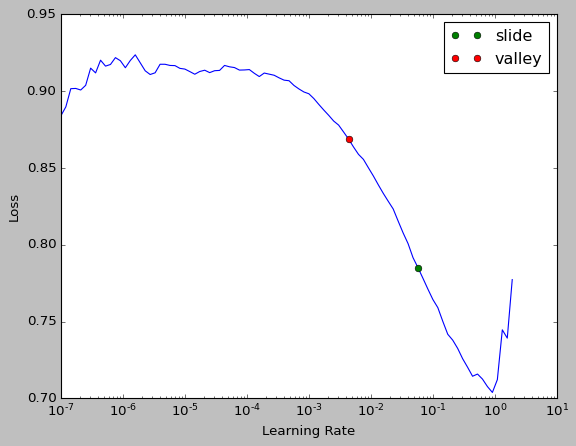

In [ ]:
learn.lr_find(suggest_funcs=(slide, valley))

## Training the model:

In [ ]:
learn = tabular_learner(dls, layers = [20,20], metrics=accuracy)
learn.fit(20, lr=0.005)

epoch,train_loss,valid_loss,accuracy,time
0,0.717182,0.689803,0.605364,00:00
1,0.670703,0.611701,0.731801,00:00
2,0.619985,0.533585,0.743295,00:00
3,0.576716,0.498497,0.773946,00:00
4,0.542172,0.489277,0.762452,00:00
5,0.518437,0.477356,0.785441,00:00
6,0.499243,0.472990,0.777778,00:00
7,0.483240,0.466630,0.773946,00:00
8,0.472140,0.475360,0.781609,00:00
9,0.463333,0.472392,0.785441,00:00


## Fast.ai final accuracy = 80%

## The confusion matrix for correct and incorrect predictions:

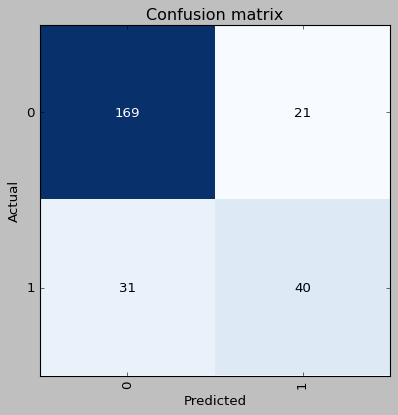

In [ ]:
# Plot the confusion matrix:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))

## Data visualization time:

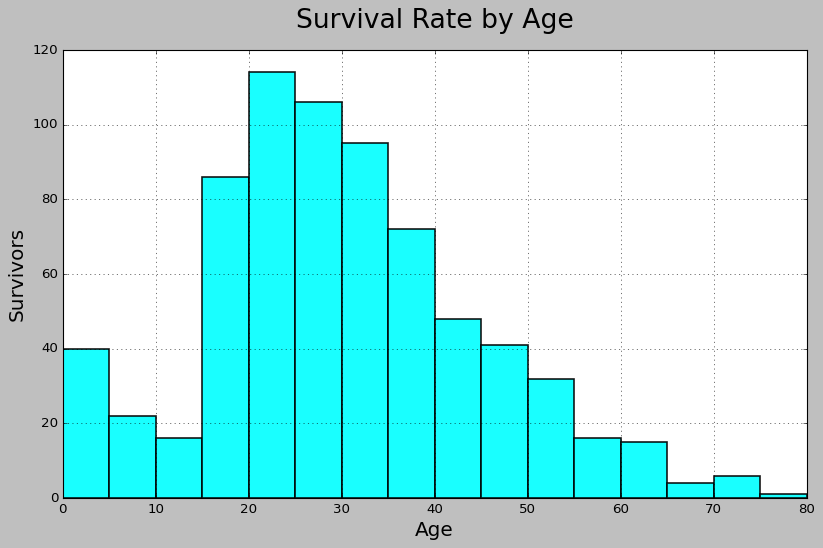

In [ ]:
# Plot the survival rate by age:
plt.style.use('classic')
fig = plt.figure(figsize=(12,7))
df = pd.read_csv('train.csv')
df['Age'].hist(bins=16, range=(0,80), alpha = .9, color='cyan', edgecolor='black',  linewidth=1.5)
plt.title("Survival Rate by Age", pad=20, size=24)
plt.xlabel('Age', size=18)
plt.ylabel('Survivors', size=18)
plt.show()

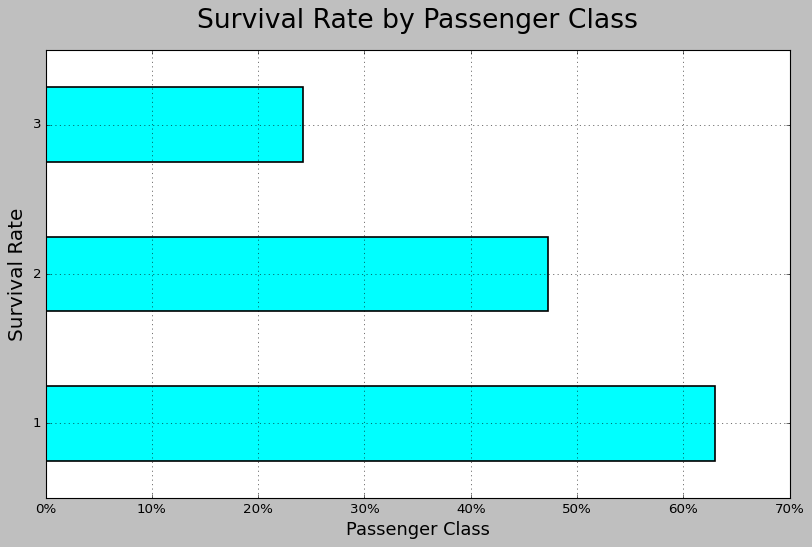

In [ ]:
# Plot the percentage of survivors by passenger class in a bar chart:
plt.style.use('classic')
fig = plt.figure(figsize=(12,7))
df = pd.read_csv('train.csv')
df.groupby('Pclass')['Survived'].mean().plot(kind='barh', color='cyan', edgecolor='black',  linewidth=1.5)
# Make the x axis labels as percentages:
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()])
plt.grid()
plt.title("Survival Rate by Passenger Class", pad=20, size=24)
plt.xlabel('Passenger Class', size=16)
plt.ylabel('Survival Rate', size=18)
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


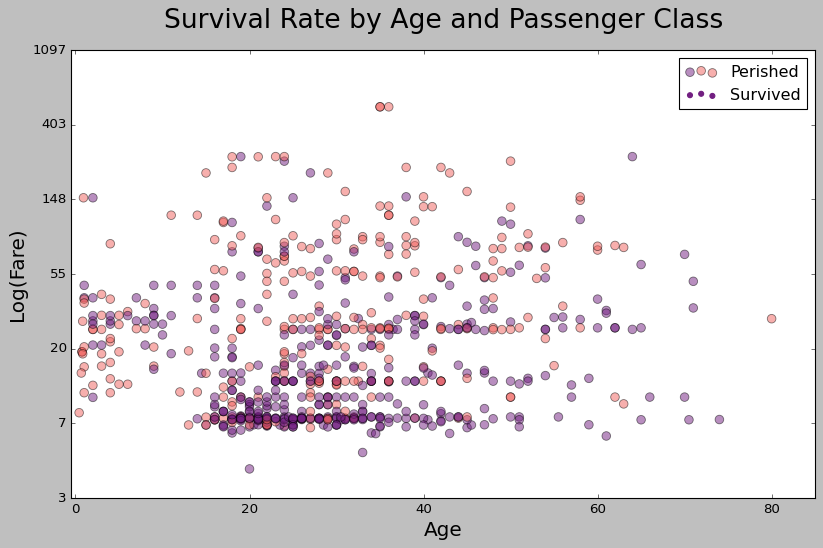

In [ ]:
import seaborn as sns
# Make an sns scatterplot of suvivors by age, sex, and passenger class:
plt.style.use('classic')
fig = plt.figure(figsize=(12,7))
df = pd.read_csv('train.csv')
# Set axis limits:
plt.xlim(-0.5, 85)
plt.ylim(1, 7)
sns.scatterplot(x='Age', y=np.log(df['Fare']), hue='Survived', data=df, palette='magma', alpha=0.5, s=60, linewidth=0.75, edgecolor='black')
# Make the y axis labels as the fare before the log:
plt.gca().set_yticklabels(['{:.0f}'.format(np.exp(x)) for x in plt.gca().get_yticks()])
plt.title("Survival Rate by Age and Passenger Class", pad=20, size=24)
plt.xlabel('Age', size=18)
plt.ylabel('Log(Fare)', size=18)
# Legend, make 0 and 1 into 'Perished' and 'Survived':
plt.legend(['Perished', 'Survived'])
plt.show()

---
# XGBoost Version

## Importing all the necessary libraries:

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from urllib.request import urlretrieve
url = "http://www.evanmarie.com/content/files/datasets/titanic.zip"
urlretrieve(url, 'titanic.zip')

from zipfile import ZipFile
with ZipFile('titanic.zip') as file:
  file.extractall()

## Creating the dataframes and cleaning up the data:

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
# Clean up column names (lower case and strip spaces):
train_df.columns = [x.lower().strip() for x in train_df.columns]
test_df.columns = [x.lower().strip() for x in test_df.columns]

# Combine train_df and test_df:
titanic_df = pd.concat([train_df, test_df], sort=False)

# Drop columns that are not useful:
titanic_df.drop(['ticket', 'cabin', 'name', 'passengerid'], axis=1, inplace=True)

# Rename columns:
titanic_df = titanic_df.rename(columns={
    'pclass': 'passenger_class',
    'sibsp': 'siblings_spouses',
    'parch': 'parents_children',
    'embarked': 'embark_town'
})

In [ ]:
# Log version of fare
titanic_df['fare'] = np.log(titanic_df['fare'] + 1)

# Alone column is 1 if no siblings/spouses or parents/children:
titanic_df['alone'] = 0
titanic_df.loc[(titanic_df['siblings_spouses'] == 0) & (titanic_df['parents_children'] == 0), 'alone'] = 1

# Total family members:
titanic_df['family_members'] = titanic_df['siblings_spouses'] + titanic_df['parents_children']
# Drop the siblings_spouses and parents_children columns:
titanic_df.drop(['siblings_spouses', 'parents_children'], axis=1, inplace=True)
titanic_df['survived'] = titanic_df['survived'].fillna(0).astype(int)

## One-hot encoding categorical data:

In [ ]:
titanic_df = pd.get_dummies(titanic_df, columns=['passenger_class', 'sex', 'embark_town'])

## Scaling the data:

In [ ]:
scaler = MinMaxScaler()
titanic_df['age'] = scaler.fit_transform(titanic_df['age'].values.reshape(-1,1))
# Fill NaN values with the mean of the column:
titanic_df.fillna(titanic_df.mean(), inplace=True)

In [ ]:
# Get a correlation matrix of the features:
titanic_df.corr()

,survived,age,fare,alone,family_members,passenger_class_1,passenger_class_2,passenger_class_3,sex_female,sex_male,embark_town_C,embark_town_Q,embark_town_S
survived,1.000000,-0.060203,0.238147,-0.154285,0.020555,0.208166,0.062279,-0.231169,0.404020,-0.404020,0.096513,-0.012730,-0.082581
age,-0.060203,1.000000,0.173183,0.116675,-0.196996,0.362587,-0.014193,-0.302093,-0.057397,0.057397,0.076179,-0.012718,-0.064267
fare,0.238147,0.173183,1.000000,-0.469704,0.381755,0.679077,-0.027350,-0.565151,0.250265,-0.250265,0.281942,-0.190547,-0.132273
alone,-0.154285,0.116675,-0.469704,1.000000,-0.688864,-0.126551,-0.035075,0.138250,-0.284537,0.284537,-0.107874,0.127214,0.011527
family_members,0.020555,-0.196996,0.381755,-0.688864,1.000000,-0.029656,-0.039976,0.058430,0.188583,-0.188583,-0.036553,-0.087190,0.089503
passenger_class_1,0.208166,0.362587,0.679077,-0.126551,-0.029656,1.000000,-0.296526,-0.622172,0.107371,-0.107371,0.325722,-0.166101,-0.187353
passenger_class_2,0.062279,-0.014193,-0.027350,-0.035075,-0.039976,-0.296526,1.000000,-0.563180,0.028862,-0.028862,-0.134675,-0.121973,0.197973
passenger_class_3,-0.231169,-0.302093,-0.565151,0.138250,0.058430,-0.622172,-0.563180,1.000000,-0.116562,0.116562,-0.171430,0.243706,-0.000181
sex_female,0.404020,-0.057397,0.250265,-0.284537,0.188583,0.107371,0.028862,-0.116562,1.000000,-1.000000,0.066564,0.088651,-0.119504
sex_male,-0.404020,0.057397,-0.250265,0.284537,-0.188583,-0.107371,-0.028862,0.116562,-1.000000,1.000000,-0.066564,-0.088651,0.119504


## Looking feature correlations:

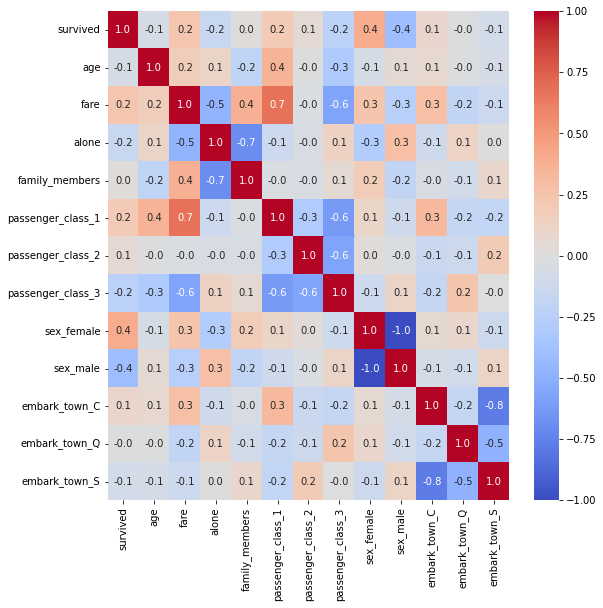

In [ ]:
# Plot a correlation matrix:
plt.figure(figsize=(9,9))
sns.heatmap(titanic_df.corr(), annot=True, fmt='.1f', cmap='coolwarm')
plt.show()

## Train-test splitting:

In [ ]:
# Split the data into training and test sets:
train_in, test_in, train_tar, test_tar = train_test_split(titanic_df.drop('survived', axis = 1), 
                                                          titanic_df['survived'], test_size=0.2, 
                                                          random_state=42)

## Determining optimal hyperparameter values:

In [ ]:
predictions = xgb_model.predict(test_in)

In [ ]:
rmse = mean_squared_error

def test_parameters(**params):
    model = XGBClassifier(objective="reg:squarederror", n_jobs=-1, random_state=42, **params)
    model.fit(train_in, train_tar)
    train_rmse = rmse(model.predict(train_in), train_tar)
    val_rmse = rmse(model.predict(test_in), test_tar)
    return train_rmse, val_rmse

def compare_number_estimators(iterations, estimator_increment):
  comparison_num_estimators = []
  estimator_count = 10
  train_rmse = 0
  val_rmse = 0

  for iteration in range(iterations):
      train_rmse, val_rmse = test_parameters(n_estimators = estimator_count)
      comparison_num_estimators.append([iteration, estimator_count, train_rmse, val_rmse])
      print(f"XGBoost on iteration number {iteration + 1} of {iterations} with {estimator_count} estimators")
      print(f"received a combined training RMSE of {train_rmse: .2f}")
      print(f"and a combined validation RMSE of {val_rmse: .2f}. \n")
      estimator_count += estimator_increment

  comparison_num_estimators = pd.DataFrame(comparison_num_estimators, columns = ['iteration', 'num_estimators', "training_rmse", "validation_rmse"])
  return(comparison_num_estimators)

In [ ]:
compare_number_estimators(10, 10)

XGBoost on iteration number 1 of 10 with 10 estimators
received a combined training RMSE of  0.19
and a combined validation RMSE of  0.21. 

XGBoost on iteration number 2 of 10 with 20 estimators
received a combined training RMSE of  0.19
and a combined validation RMSE of  0.22. 

XGBoost on iteration number 3 of 10 with 30 estimators
received a combined training RMSE of  0.18
and a combined validation RMSE of  0.22. 

XGBoost on iteration number 4 of 10 with 40 estimators
received a combined training RMSE of  0.18
and a combined validation RMSE of  0.21. 

XGBoost on iteration number 5 of 10 with 50 estimators
received a combined training RMSE of  0.17
and a combined validation RMSE of  0.21. 

XGBoost on iteration number 6 of 10 with 60 estimators
received a combined training RMSE of  0.17
and a combined validation RMSE of  0.21. 

XGBoost on iteration number 7 of 10 with 70 estimators
received a combined training RMSE of  0.17
and a combined validation RMSE of  0.21. 

XGBoost on it

,iteration,num_estimators,training_rmse,validation_rmse
0,0,10,0.190067,0.213740
1,1,20,0.185291,0.217557
2,2,30,0.180516,0.217557
3,3,40,0.176695,0.213740
4,4,50,0.170965,0.209924
5,5,60,0.170010,0.209924
6,6,70,0.166189,0.209924
7,7,80,0.165234,0.202290
8,8,90,0.159503,0.206107
9,9,100,0.159503,0.209924


In [ ]:
def test_accuracy_estimators(intial_num_estimators, num_estimators_increment, 
                  train_inputs, train_targets, test_inputs, test_targets):
    num_estimators = intial_num_estimators
    accuracy = []
    while num_estimators <= 200:
        model = XGBClassifier(n_estimators=num_estimators)
        model.fit(train_inputs, train_targets)
        print(f'Accuracy: {model.score(test_inputs, test_targets)*100: .2f}% | n_estimators =  {num_estimators}')
        accuracy.append(model.score(test_inputs, test_targets))
        num_estimators += num_estimators_increment

In [ ]:
test_accuracy_estimators(10, 4, train_in, train_tar, test_in, test_tar)

Accuracy:  78.63% | n_estimators =  10
Accuracy:  78.63% | n_estimators =  14
Accuracy:  78.63% | n_estimators =  18
Accuracy:  78.63% | n_estimators =  22
Accuracy:  78.24% | n_estimators =  26
Accuracy:  78.63% | n_estimators =  30
Accuracy:  77.86% | n_estimators =  34
Accuracy:  78.63% | n_estimators =  38
Accuracy:  78.63% | n_estimators =  42
Accuracy:  79.01% | n_estimators =  46
Accuracy:  79.01% | n_estimators =  50
Accuracy:  79.01% | n_estimators =  54
Accuracy:  79.01% | n_estimators =  58
Accuracy:  78.24% | n_estimators =  62
Accuracy:  78.63% | n_estimators =  66
Accuracy:  78.63% | n_estimators =  70
Accuracy:  78.24% | n_estimators =  74
Accuracy:  78.63% | n_estimators =  78
Accuracy:  78.63% | n_estimators =  82
Accuracy:  77.48% | n_estimators =  86
Accuracy:  77.10% | n_estimators =  90
Accuracy:  77.48% | n_estimators =  94
Accuracy:  77.10% | n_estimators =  98
Accuracy:  76.72% | n_estimators =  102
Accuracy:  76.34% | n_estimators =  106
Accuracy:  76.34% | n_e

### Best `n_estimators = 50`

In [ ]:
# Function that tests the accuracy based on the learning rate parameter for a given number of epochs:

def test_accuracy_learning_rate(epochs, initial_lr, lr_incrememnt, train_inputs, train_targets, test_inputs, test_targets):
    lr = initial_lr
    accuracy = []
    count = 0
    while count <= epochs+1:
        model = XGBClassifier(learning_rate=lr)
        model.fit(train_inputs, train_targets)
        print(f'Accuracy: {model.score(test_inputs, test_targets)*100: .2f}% | learning_rate =  {lr: .4f}')
        accuracy.append(model.score(test_inputs, test_targets))
        lr += lr_incrememnt
        count += 1

In [ ]:
test_accuracy_learning_rate(100, 0.001, 0.001, train_in, train_tar, test_in, test_tar)

Accuracy:  78.63% | learning_rate =   0.0010
Accuracy:  78.63% | learning_rate =   0.0020
Accuracy:  78.63% | learning_rate =   0.0030
Accuracy:  78.63% | learning_rate =   0.0040
Accuracy:  78.63% | learning_rate =   0.0050
Accuracy:  78.63% | learning_rate =   0.0060
Accuracy:  78.63% | learning_rate =   0.0070
Accuracy:  78.63% | learning_rate =   0.0080
Accuracy:  78.63% | learning_rate =   0.0090
Accuracy:  78.63% | learning_rate =   0.0100
Accuracy:  78.63% | learning_rate =   0.0110
Accuracy:  78.63% | learning_rate =   0.0120
Accuracy:  78.63% | learning_rate =   0.0130
Accuracy:  78.63% | learning_rate =   0.0140
Accuracy:  78.63% | learning_rate =   0.0150
Accuracy:  78.63% | learning_rate =   0.0160
Accuracy:  78.63% | learning_rate =   0.0170
Accuracy:  78.63% | learning_rate =   0.0180
Accuracy:  78.63% | learning_rate =   0.0190
Accuracy:  78.63% | learning_rate =   0.0200
Accuracy:  78.63% | learning_rate =   0.0210
Accuracy:  78.63% | learning_rate =   0.0220
Accuracy: 

### Best `lr = 0.05`

In [ ]:
# Function to test the accuracy based on the max_depth parameter:
def test_accuracy_max_depth(epochs, initial_max_depth, max_depth_increment, train_inputs, train_targets, test_inputs, test_targets):
    max_depth = initial_max_depth
    accuracy = []
    count = 0
    while count <= epochs+1:
        model = XGBClassifier(max_depth=max_depth)
        model.fit(train_inputs, train_targets)
        print(f'Accuracy: {model.score(test_inputs, test_targets)*100: .2f}% | max_depth =  {max_depth}')
        accuracy.append(model.score(test_inputs, test_targets))
        max_depth += max_depth_increment
        count += 1

In [ ]:
test_accuracy_max_depth(20, 2, 2, train_in, train_tar, test_in, test_tar)

Accuracy:  79.77% | max_depth =  2
Accuracy:  74.43% | max_depth =  4
Accuracy:  75.57% | max_depth =  6
Accuracy:  73.28% | max_depth =  8
Accuracy:  74.05% | max_depth =  10
Accuracy:  74.81% | max_depth =  12
Accuracy:  74.05% | max_depth =  14
Accuracy:  74.05% | max_depth =  16
Accuracy:  73.28% | max_depth =  18
Accuracy:  72.90% | max_depth =  20
Accuracy:  72.90% | max_depth =  22
Accuracy:  74.05% | max_depth =  24
Accuracy:  72.90% | max_depth =  26
Accuracy:  72.90% | max_depth =  28
Accuracy:  72.90% | max_depth =  30
Accuracy:  72.90% | max_depth =  32
Accuracy:  72.90% | max_depth =  34
Accuracy:  72.90% | max_depth =  36
Accuracy:  72.90% | max_depth =  38
Accuracy:  72.90% | max_depth =  40
Accuracy:  72.90% | max_depth =  42
Accuracy:  72.90% | max_depth =  44


### Best `max_depth = 2`

In [ ]:
xgb_model = XGBClassifier(objective="reg:squarederror", 
                          random_state=42, max_depth = 2,
                          n_estimators = 50, lr = 0.05)

## Defining the model:

In [ ]:
xgb_model.fit(train_in, train_tar)

XGBClassifier(lr=0.05, max_depth=2, n_estimators=50,
              objective='reg:squarederror', random_state=42)

In [ ]:
predictions = xgb_model.predict(test_in)

## Top feature importance:

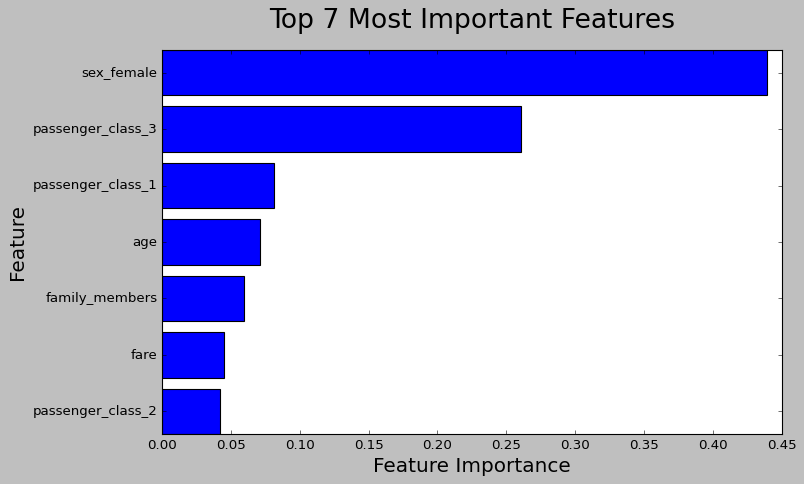

In [ ]:
# Plot the top 7 most important features in a horizontal bar graph by order of importance
plt.style.use('classic')
fig = plt.figure(figsize=(10,6))
plt.barh(titanic_df.drop('survived', axis=1).columns[xgb_model.feature_importances_.argsort()][-7:],
            xgb_model.feature_importances_[xgb_model.feature_importances_.argsort()][-7:])
plt.title('Top 7 Most Important Features', pad=20, size=24)
plt.xlabel('Feature Importance', size=18)
plt.ylabel('Feature', size=18)
plt.show()

## Final accuracy for XGBoost:

In [ ]:
# Get the accuracy score of the model:
print(f'Accuracy: {xgb_model.score(test_in, test_tar)*100: .2f}%')

Accuracy:  78.24%
